# Surface classification using 2-forms

In this notebook we use $2$-forms to classify surfaces at the end of the model we incorporate an MLP for classification. 

In [1]:
import numpy as np
import matplotlib as mpl
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import math
import gudhi as gd 
import scipy.special

import k_forms as kf
import k_forms_visual as vis 


import torch.optim as optim

%load_ext autoreload
%autoreload 2

[[0, 1, 5], [1, 2, 6], [1, 5, 6], [2, 3, 7], [2, 6, 7], [3, 4, 8], [3, 7, 8], [4, 8, 9], [5, 6, 10], [6, 7, 11], [6, 10, 11], [7, 8, 12], [7, 11, 12], [8, 9, 13], [8, 12, 13], [9, 13, 14], [10, 11, 15], [11, 12, 16], [11, 15, 16], [12, 13, 17], [12, 16, 17], [13, 14, 18], [13, 17, 18], [14, 18, 19], [15, 16, 20], [16, 17, 21], [16, 20, 21], [17, 18, 22], [17, 21, 22], [18, 19, 23], [18, 22, 23], [19, 23, 24]]


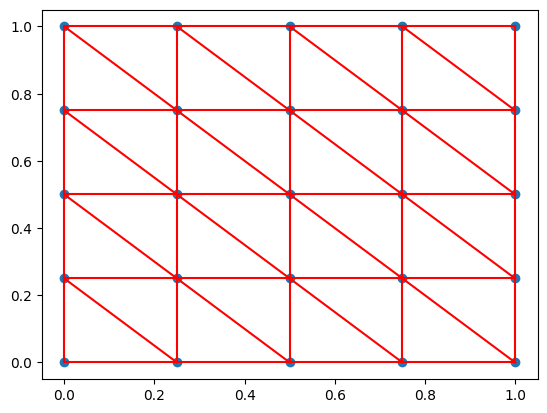

In [2]:
num_pts = 5 
pts , ac = kf.plot_unit_square_grid(num_pts)
simplices = []
for s in ac.get_skeleton(2):
    if len(s[0]) == 3: 
        simplices.append(s[0])

print(simplices)

In [3]:
# generate surface data
num_surf = 20
eps = 3
s0 = kf.generate_surfaces_yz(num_surf, num_pts , eps) ## the surfaces are a bit too regular, change a bit the generation code later
s1 = kf.generate_surfaces_xz(num_surf, num_pts , eps)
#s2 = kf.generate_curved_surfaces(num_surf, num_pts , eps)
surfaces = s0 + s1 

# generate labels
#labels = np.concatenate((np.zeros(num_surf),np.ones(num_surf),2*np.ones(num_surf)))
labels = np.concatenate((np.zeros(num_surf),np.ones(num_surf)))

# perform a one hot encoding of the labels and transform to torch
labels_one_hot = torch.nn.functional.one_hot(torch.tensor(labels).to(torch.int64))

## shuffle the data and the labels in the same way
shuffled_indices = torch.randperm(len(surfaces)) 
surfaces_shuffled = [surfaces[i] for i in shuffled_indices]
labels_one_hot_shuffled = labels_one_hot[shuffled_indices]
labels_shuffled = labels[shuffled_indices]

In [4]:
## making dictionaries out of the surfaces
## decide if shuffle or not when doing this 
surfaces_list = []
for surf in range(num_surf*2): 
    surface = surfaces[surf]
    surface_dict= {}
    surface_dict['simplices'] = simplices
    surface_dict['points'] = surface[3]
    surface_dict['Phi'] = []
    surface_dict['b'] = []


    for i in range(len(surface_dict['simplices'])):
        s = surface_dict['simplices'][i]
        emb_vertices_simplex = surface_dict['points'][s]
        phi_simplex, b_simplex = kf.phi_b(emb_vertices_simplex )
        surface_dict['Phi'].append(phi_simplex)
        surface_dict['b'].append(b_simplex)

    surfaces_list.append(surface_dict)

surfaces_list_shuffled = [surfaces_list[i] for i in shuffled_indices]

len(surfaces_list_shuffled)

40

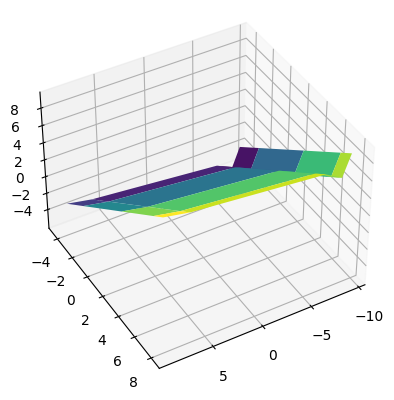

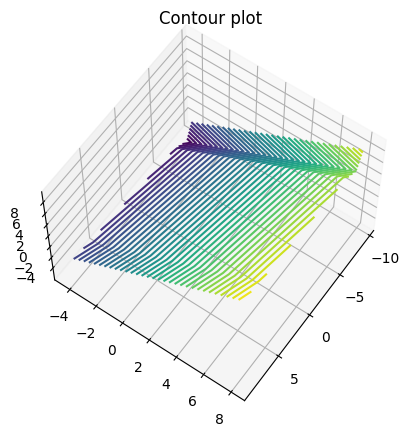

In [17]:
# plot one surface
kf.plot_surface(surfaces[5][0],surfaces[5][1],surfaces[5][2])

# Learn multiple cochains

In [9]:
def integrate_kforms(kform, phi, b, det, subdivision_vert, subdivision_coefs, num_sub, l =1, dim = 3, k = 2):
    """ Integrate l 2-forms over 2-simplex
    Input: 
        kform: l 2-forms
        phi: a matrix containing the embedding of the vertices of the simplex in R^dim
        b: a vector containing the embedding of the basepoint of the simplex in R^dim
        det: the tensor computed by build_determinant_tensor
        l: the number of 2-forms to integrate
        dim: the dimension of the embedding space
        k: the dimension of the form
        subdivision_vert: a list of vertices of the subdivision of the simplex
        subdivision_coefs: a list of coefficients for the contribution of each vertex to the integral
        num_sub: the number of subdivisions of the simplex 
    Output:
        integral: the value of integral of the l 2-forms over the 2-simplex 
    """

    ## TODO: add assert to check inputs 
    ## check  that l and the shape of the k-form are consistent

    ## number of vertices in the subdivision
    num_simplices = int(num_sub**2) ## number of simplices in the subdivision

    N = int(scipy.special.binom(dim,k))

    integrals = torch.zeros(l,1) 

    for i in range(l):
        ## integrate the i-th k-form
        for j in range(len(subdivision_vert)): 
            p = subdivision_vert[j]
            phi_p = phi.T @ p + b
            g_p = torch.tensor([0]).float() 
            for ind in range(i*N, (i+1)*N):
                m = ind - i*N
                #print('m:',m)
                #print('ind: ',ind)
                #print('kform: ',kform(phi_p)[ind])
                
                g_p+= kform(phi_p)[ind] * torch.matmul(torch.matmul(phi[0], det[m]), phi[1].T)
            
            cof = subdivision_coefs[j]


            integrals[i] += torch.mul(g_p,cof)

        vol = torch.tensor([1/(2*(num_sub**2))]).float()
        
    return   ((vol/num_simplices)*integrals).float()

def forms2cochains(kform,surface_dict, deter_tensor, subdivision_vert, subdivision_coef, num_sub, l = 1, dim = 3, k = 2):
    Emb_comp = surface_dict['points']

    assert Emb_comp.shape[1] == dim, "The dimension of the embedding space is not equal to the number of columns of the matrix Emb_comp"
    
    cochains = torch.zeros(len(surface_dict['simplices']),l)   
    
    #deter_tensor = build_determinant_tensor(dim, k)
    for i in range(len(simplices)):
       
        phi_simplex = surface_dict['Phi'][i]
        b_simplex = surface_dict['b'][i]
        cochains[i] = integrate_kforms(kform, phi_simplex, b_simplex,deter_tensor, subdivision_vert, subdivision_coef, num_sub, l, dim, k)[:,0].float()
    return cochains.float()



k = 2 
dim = 3 
classes = 2
num_cochains = 2 ## number of k-forms to learn 

N = int(scipy.special.binom(dim,k))

kforms = nn.Sequential(
    nn.Linear(dim, N*num_cochains) ## can add layers here if needed
)

## Mlp layers post integration

mlp = nn.Sequential(
    nn.Linear(num_cochains, 50),
    nn.ReLU(),
    nn.Linear(50, 10),
    nn.ReLU(),
    nn.Linear(10, classes)
)

In [14]:
k = 2 
dim = 3 
## Precomputed things: 
det = kf.build_determinant_tensor(dim, k) ## will be needed for integration 
print(k)
print(dim)
print(det.shape)

num_sub = 2
vertices, coefs = kf.subdivide_simplex_coef_torch(num_sub)


2
3
torch.Size([3, 3, 3])


In [ ]:
filename = try_num = 3
filename = 'multiple_cochains_try'+str(try_num)

classes = 2
num_cochains = 2 ## number of k-forms to learn 

N = int(scipy.special.binom(dim,k))

kforms = nn.Sequential(
    nn.Linear(dim, N*num_cochains) ## can add layers here if needed
)

## Mlp layers post integration

mlp = nn.Sequential(
    nn.Linear(num_cochains, 10),
    nn.ReLU(),
    nn.Linear(10, classes)
)

In [15]:
epochs = 30

# create your optimizer
#lr = 0.1 
lr = 0.1 
#

optimizer = optim.SGD(kforms.parameters(), lr) 

criterion = nn.CrossEntropyLoss()

losses = torch.zeros(epochs)

labels_one_hot_shuffled = labels_one_hot_shuffled.to(torch.float32)

torch.autograd.set_detect_anomaly(True)

Accuracies = []
Losses= []

for e in range(epochs):
    print('epoch: ', e)
    
    correct = 0
    total = 0

    for i in range(len(surfaces_list_shuffled)):
        surface_dict= surfaces_list_shuffled[i]
        l = labels_one_hot_shuffled[i]
        
        X = kf.forms2cochains(kforms, surface_dict, det,vertices, coefs, num_sub, num_cochains, dim, k) ## multiple cochains 
        X = torch.reshape(X, (len(surface_dict['simplices']), num_cochains))
        X.retain_grad() 
        X = mlp(X)
        X = X.sum(0)
        X.retain_grad()
        #X.grad = None
        # softmax
        sm = torch.nn.functional.softmax(X)
        #print('softmax = ',sm)
        loss = criterion(sm,l) 
        print("loss: ", loss)
        #print('********')
        loss.backward(retain_graph=True)
        optimizer.step()
        optimizer.zero_grad()
        
        pred = torch.argmax(torch.nn.functional.softmax(X))
        #print('pred: ', pred)
        #print('label: ', torch.argmax(l))
        if pred == torch.argmax(l):
            correct += 1
        total += 1
        #print('correct: ', correct)

        if i % 10 == 0:
            print("number of surfaces processed: ", i)

    print('Accuracy of the network on the {} training surfaces at epoch {} : {} '.format(num_surf*2, e, (100 * correct / total)))
    Accuracies.append(100 * correct / total)
    Losses.append(loss)

    print('-----------')
    print('***********')
    print('-----------')



epoch:  0


/Users/celiahacker/opt/anaconda3/envs/celia/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/celiahacker/opt/anaconda3/envs/celia/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


loss:  tensor(1.3099, grad_fn=<DivBackward1>)
number of surfaces processed:  0
loss:  tensor(0.3555, grad_fn=<DivBackward1>)
loss:  tensor(1.3100, grad_fn=<DivBackward1>)
loss:  tensor(1.3129, grad_fn=<DivBackward1>)
loss:  tensor(0.3133, grad_fn=<DivBackward1>)
loss:  tensor(1.3133, grad_fn=<DivBackward1>)
loss:  tensor(1.3132, grad_fn=<DivBackward1>)
loss:  tensor(1.3037, grad_fn=<DivBackward1>)
loss:  tensor(0.6505, grad_fn=<DivBackward1>)
loss:  tensor(0.3133, grad_fn=<DivBackward1>)
loss:  tensor(1.3096, grad_fn=<DivBackward1>)
number of surfaces processed:  10
loss:  tensor(0.4408, grad_fn=<DivBackward1>)
loss:  tensor(1.0764, grad_fn=<DivBackward1>)
loss:  tensor(0.3136, grad_fn=<DivBackward1>)
loss:  tensor(1.3088, grad_fn=<DivBackward1>)
loss:  tensor(0.3864, grad_fn=<DivBackward1>)
loss:  tensor(0.3154, grad_fn=<DivBackward1>)
loss:  tensor(0.3133, grad_fn=<DivBackward1>)
loss:  tensor(0.3135, grad_fn=<DivBackward1>)
loss:  tensor(0.5828, grad_fn=<DivBackward1>)
loss:  tensor

In [16]:
filename = try_num = 2
filename = 'multiple_cochains_try'+str(try_num)

In [17]:
## save the data
import pickle
Losses = [loss.detach() for loss in Losses]
with open('kforms/multiple_kforms/'+filename+'_losses.pkl', 'wb') as f:
    pickle.dump(Losses, f)

# dump accuracies into a pickle file
with open('kforms/multiple_kforms/'+filename+'_accuracies.pkl', 'wb') as f:
    pickle.dump(Accuracies, f)

# save the model
torch.save(kforms.state_dict(), 'kforms/multiple_kforms/'+filename+'_kform_model.pt')
torch.save(mlp.state_dict(), 'kforms/multiple_kforms/'+filename+'_mlp_model.pt')

# save the surfaces
with open('kforms/multiple_kforms/'+filename+'_surfaces.pkl', 'wb') as f:
    pickle.dump(surfaces_list, f)

## Plots 

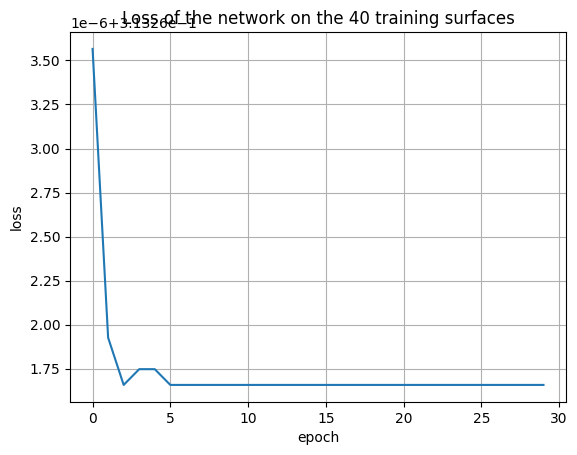

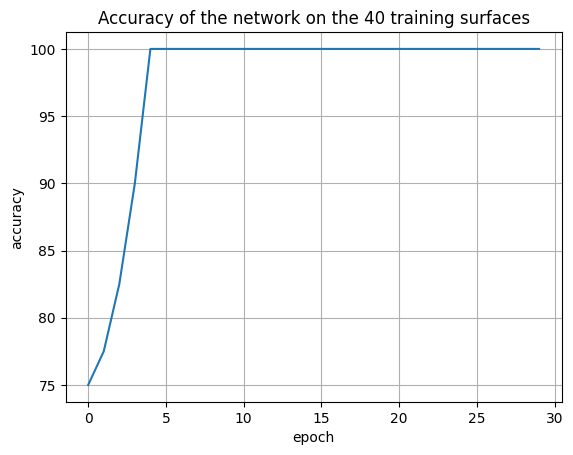

In [18]:
# plot the loss
fig, ax = plt.subplots()
ax.plot(np.arange(len(Losses)), Losses)
ax.set(xlabel='epoch', ylabel='loss', title='Loss of the network on the {} training surfaces'.format(num_surf*2))
ax.grid()
plt.show()

# plot the accuracy
fig, ax = plt.subplots()
ax.plot(np.arange(len(Accuracies)), Accuracies)
ax.set(xlabel='epoch', ylabel='accuracy', title='Accuracy of the network on the {} training surfaces'.format(num_surf*2))
ax.grid()
plt.show()

In [19]:
cochains = []
for i in range(len(surfaces_list)):
    surface_dict= surfaces_list[i]
    cochain = kf.forms2cochains(kforms, surface_dict, det,vertices, coefs, num_sub, num_cochains, dim, k) ## multiple cochains 
    cochain = cochain.detach().numpy()
    cochains.append(cochain)

# dump cochains into a pickle file
with open('kforms/multiple_kforms/'+filename+'_cochains.pkl', 'wb') as f:
    pickle.dump(cochains, f)

In [105]:
cochains[0].shape

(32, 2)

## PCA plots

In [20]:
cochain0 = [cochains[i][:,0] for i in range(len(cochains))]
cochain1 = [cochains[i][:,1] for i in range(len(cochains))]

cochain_flat = [cochains[i].flatten() for i in range(len(cochains))]

In [21]:
print(len(cochain_flat))
cochain_flat[0]

40


array([-1.5899783e+02, -4.2991920e+01, -3.5942245e+01,  1.8080582e+01,
        1.3441501e+02,  3.9272480e+01, -1.0270248e+01,  4.5520666e-01,
        2.7105007e+01, -1.2327405e+01, -1.5158136e+02, -7.5561806e+01,
        8.4091215e+00, -1.3761482e-01,  7.5134583e+01,  7.0862190e+01,
       -1.1381590e+02, -1.4337119e+01, -1.8981495e+01,  5.4617167e+00,
        9.0672005e+01,  1.1106598e+01, -5.1603274e+00, -4.4840232e-01,
        1.0681162e+01, -8.0949903e-02, -6.3792969e+01, -3.6901207e+01,
        3.4307210e+00,  7.4250937e-01, -8.6888723e+00,  3.2840508e+01,
       -6.3253929e+01,  8.3549366e+00, -3.8491552e+00, -4.3932257e+00,
        4.6469257e+01, -9.6195393e+00, -6.9176608e-01, -1.0180387e+00,
       -2.0925028e+00,  8.1537895e+00,  8.9477243e+00, -3.4399261e+00,
       -4.7282302e-01,  1.2118733e+00, -6.3540871e+01,  1.9415256e+00,
       -6.3444683e+01,  7.8355896e+01,  2.4861668e+01, -3.6252716e+01,
       -2.3358307e+00, -9.9534836e+01,  8.6351118e+00, -4.3170881e+00,
      

In [22]:
def plot_pca_kform(cochains, labels, n_components, view = None): 

    if n_components == 2: 
        pca = PCA(n_components=2)
        principalComponents = pca.fit_transform(cochains)
        principalDf = pd.DataFrame(data = principalComponents
                    , columns = ['principal component 1', 'principal component 2'])

        # add the labels to the principal components
        principalDf['labels'] = labels
        # plot the principal components
        fig, ax = plt.subplots()
        scatter = ax.scatter(principalDf['principal component 1'], principalDf['principal component 2'], c=principalDf['labels'])
        ax.set_title('PCA of the cochains')
        ax.set_xlabel('Principal Component 1')
        ax.set_ylabel('Principal Component 2')
        legend1 = ax.legend(*scatter.legend_elements(), loc="upper left", title="Classes")

        plt.show()


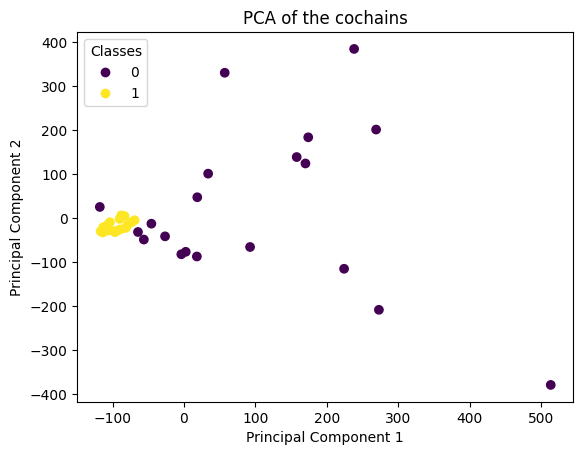

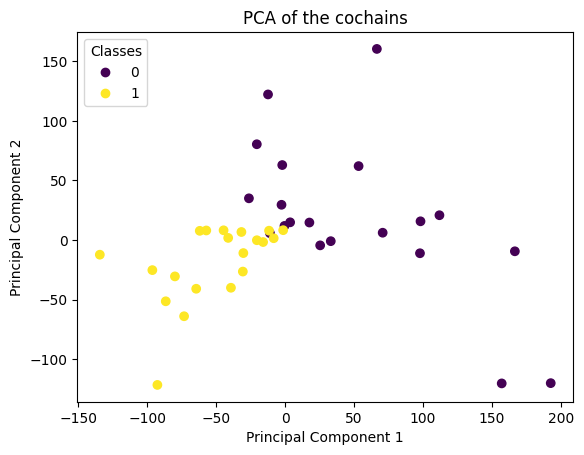

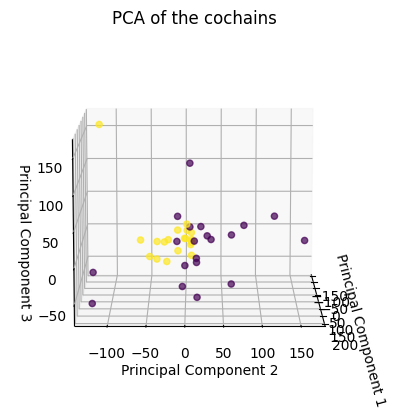

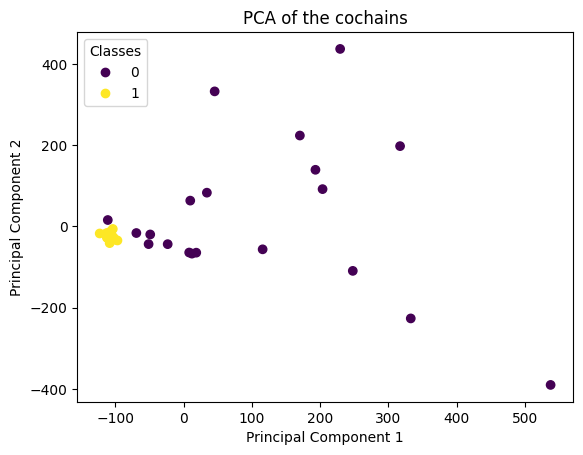

In [23]:
vis.plot_pca_kform(cochain0, labels, 2) 
vis.plot_pca_kform(cochain1, labels, 2)
vis.plot_pca_kform(cochain1, labels, 3,(10,0)) 
vis.plot_pca_kform(cochain_flat, labels, 2)


## 2. norm 

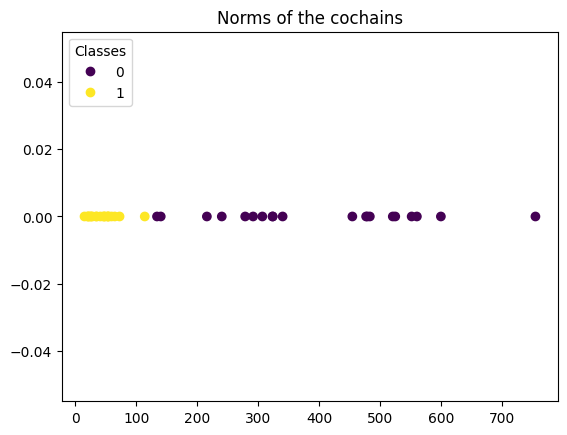

In [24]:
Norms = [np.linalg.norm(cochain) for cochain in cochain0]
fig, ax = plt.subplots()
scatter = ax.scatter(Norms, np.zeros(len(Norms)), c=labels, cmap='viridis')
legend1 = ax.legend(*scatter.legend_elements(), loc="upper left", title="Classes")
ax.set_title('Norms of the cochains')
plt.show()

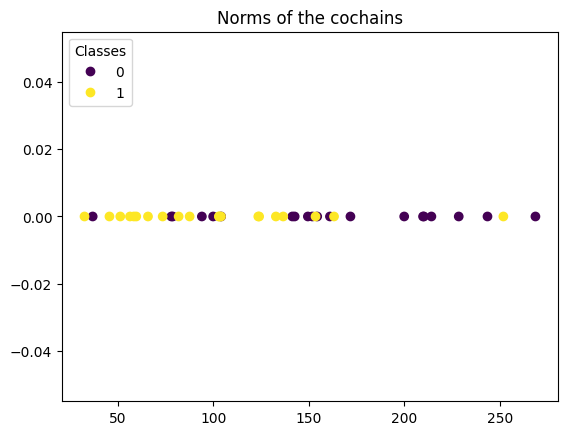

In [25]:
Norms = [np.linalg.norm(cochain) for cochain in cochain1]
fig, ax = plt.subplots()
scatter = ax.scatter(Norms, np.zeros(len(Norms)), c=labels, cmap='viridis')
legend1 = ax.legend(*scatter.legend_elements(), loc="upper left", title="Classes")
ax.set_title('Norms of the cochains')
plt.show()

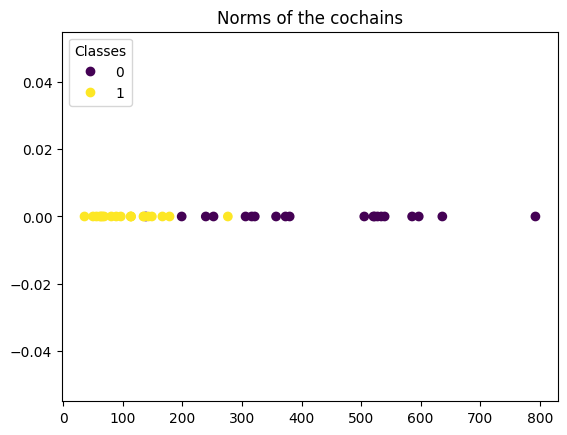

In [26]:
Norms = [np.linalg.norm(cochain) for cochain in cochain_flat]
fig, ax = plt.subplots()
scatter = ax.scatter(Norms, np.zeros(len(Norms)), c=labels, cmap='viridis')
legend1 = ax.legend(*scatter.legend_elements(), loc="upper left", title="Classes")
ax.set_title('Norms of the cochains')
plt.show()

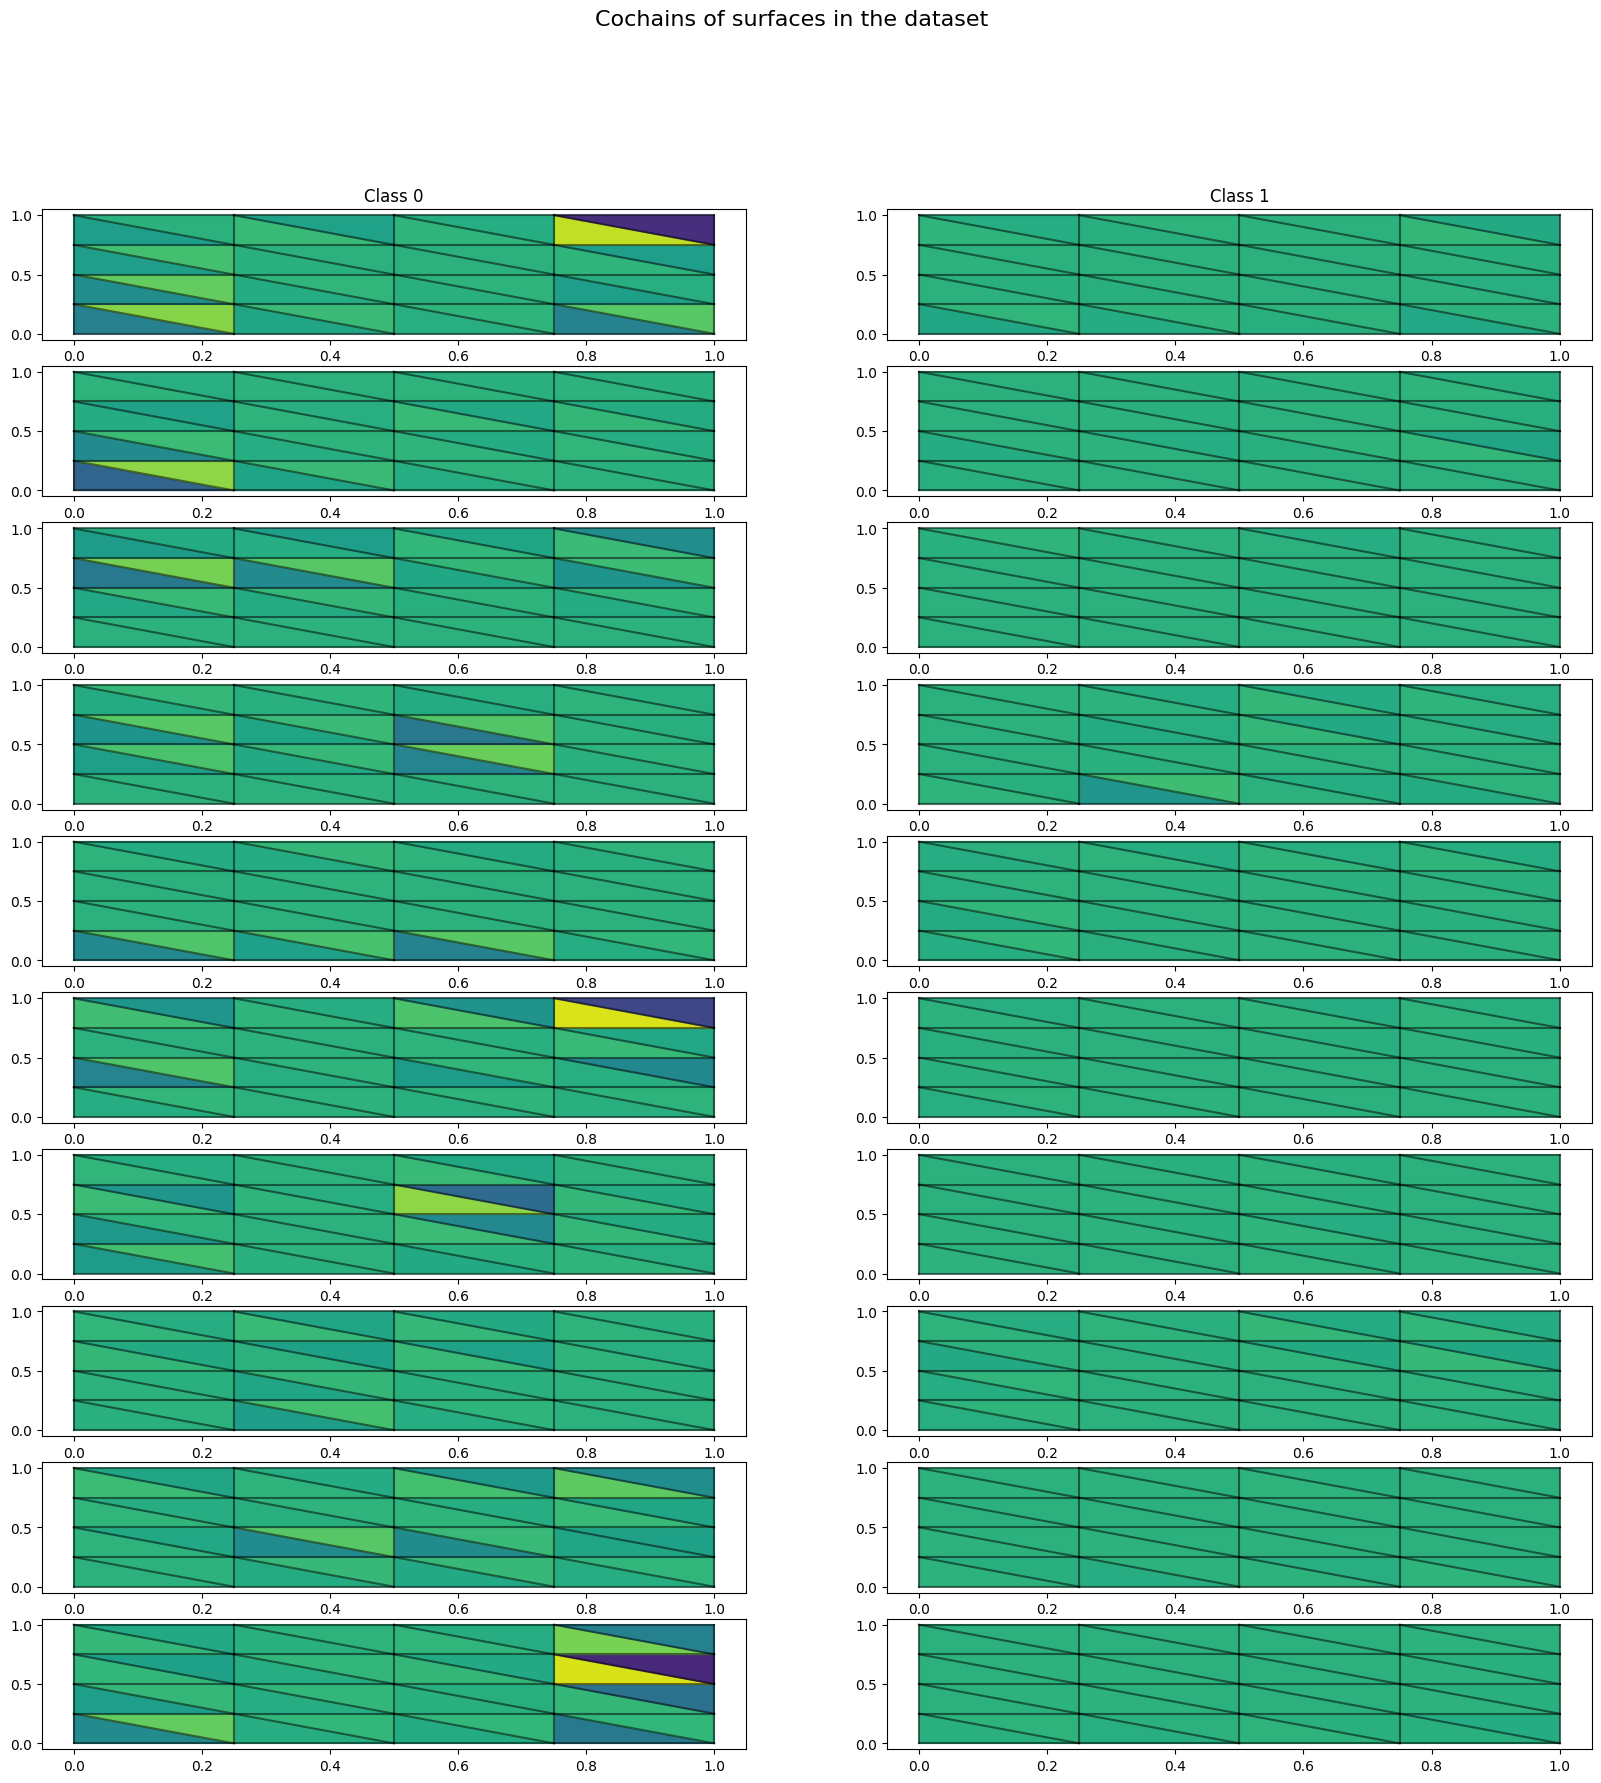

In [27]:
points = pts
vis.plot_comparison_cochains(cochain0, points, simplices, ac, 10)

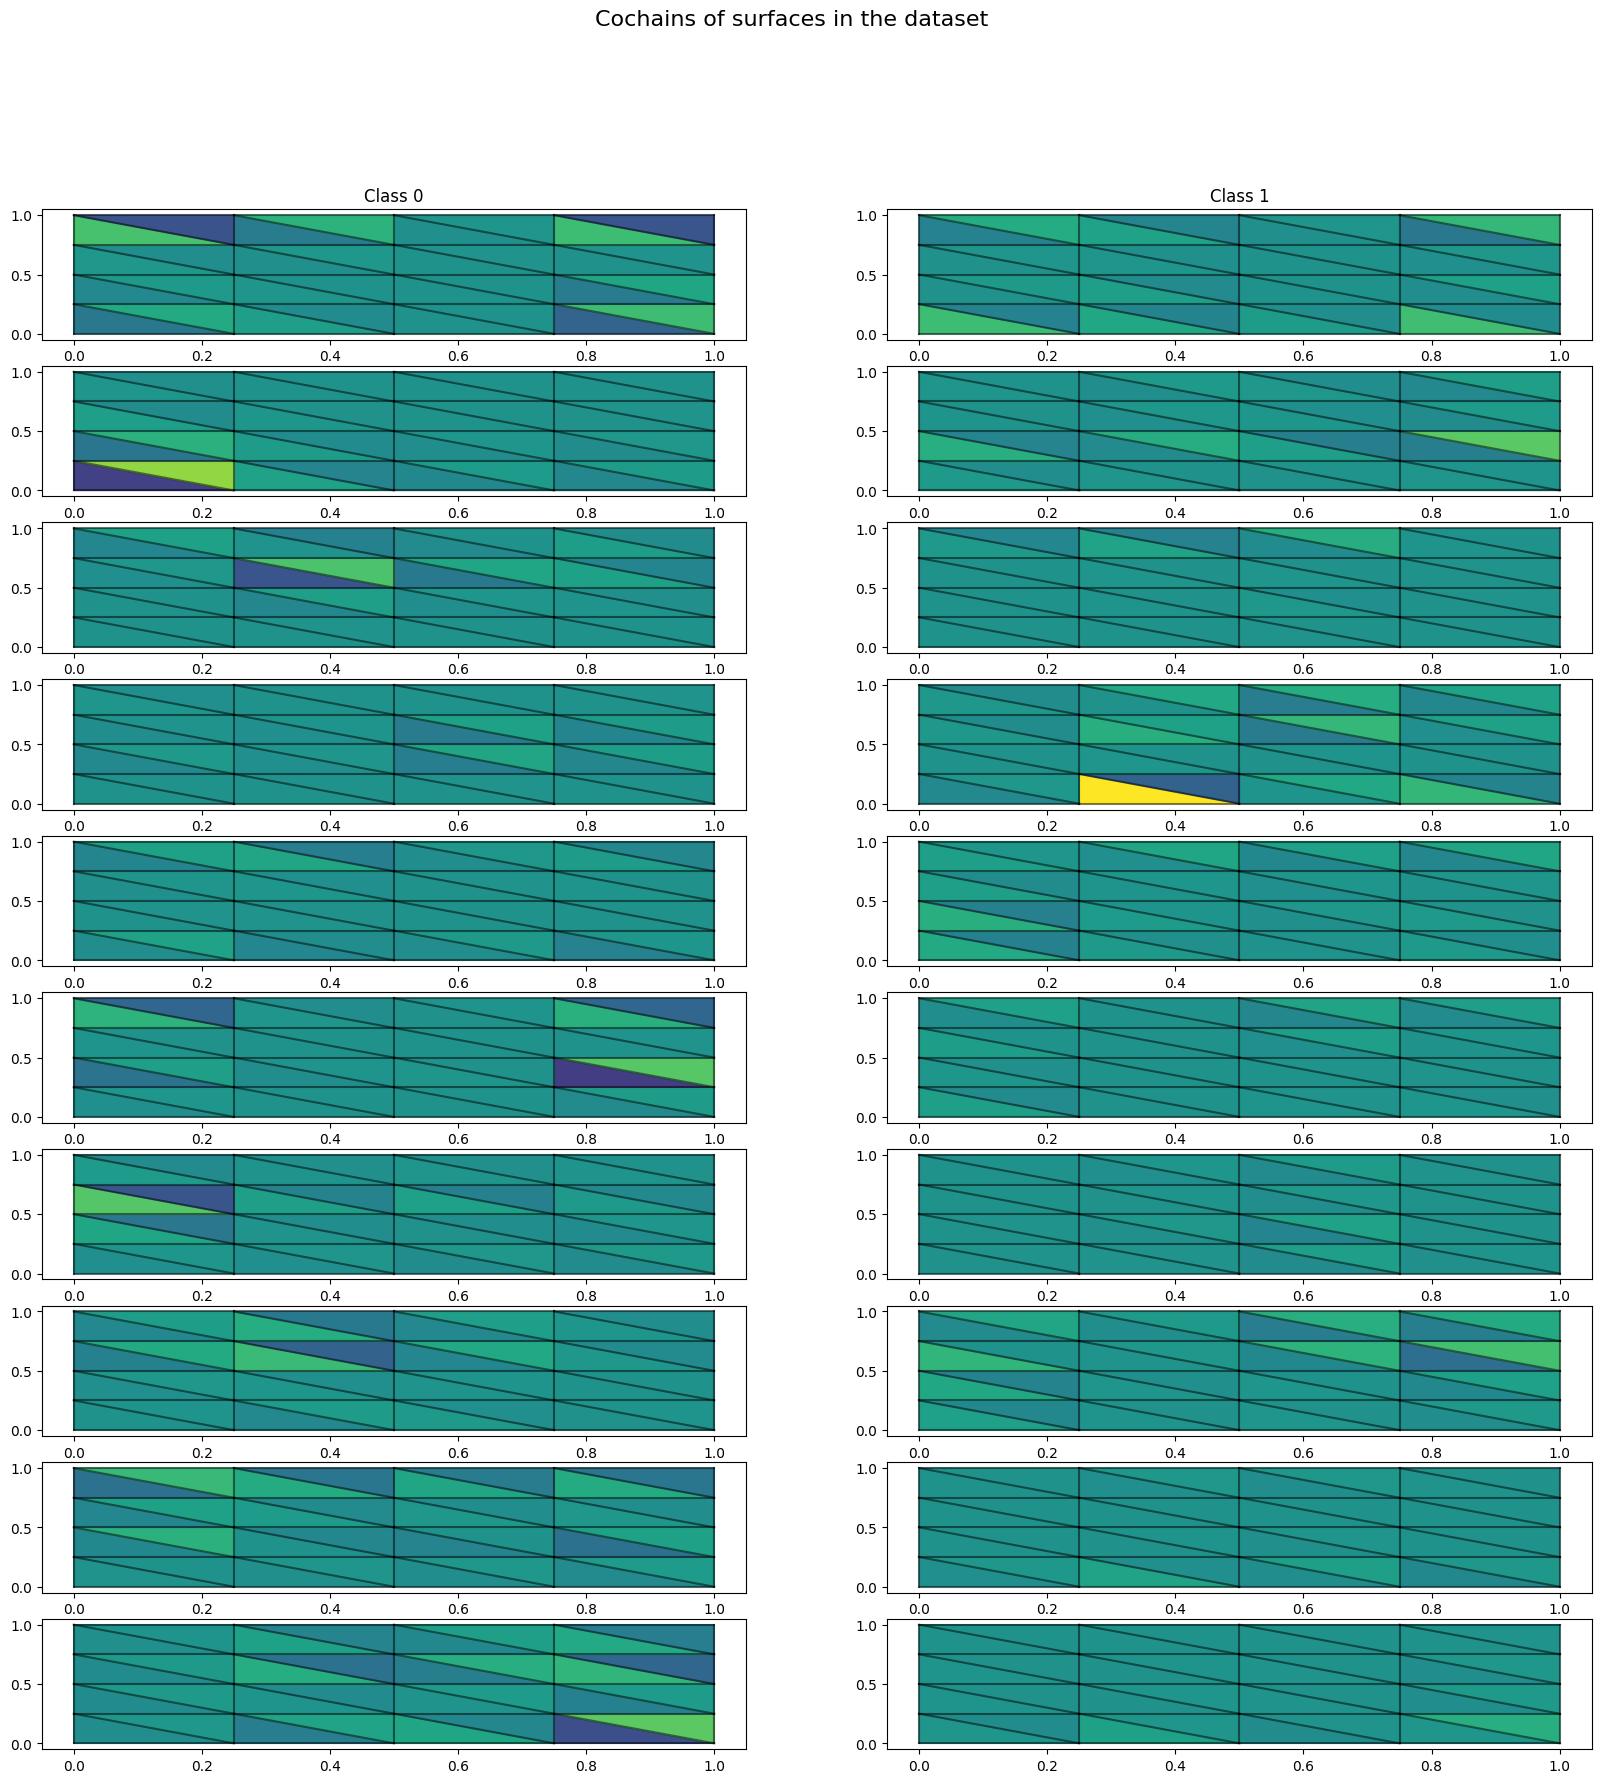

In [28]:
vis.plot_comparison_cochains(cochain1, points, simplices, ac, 10)

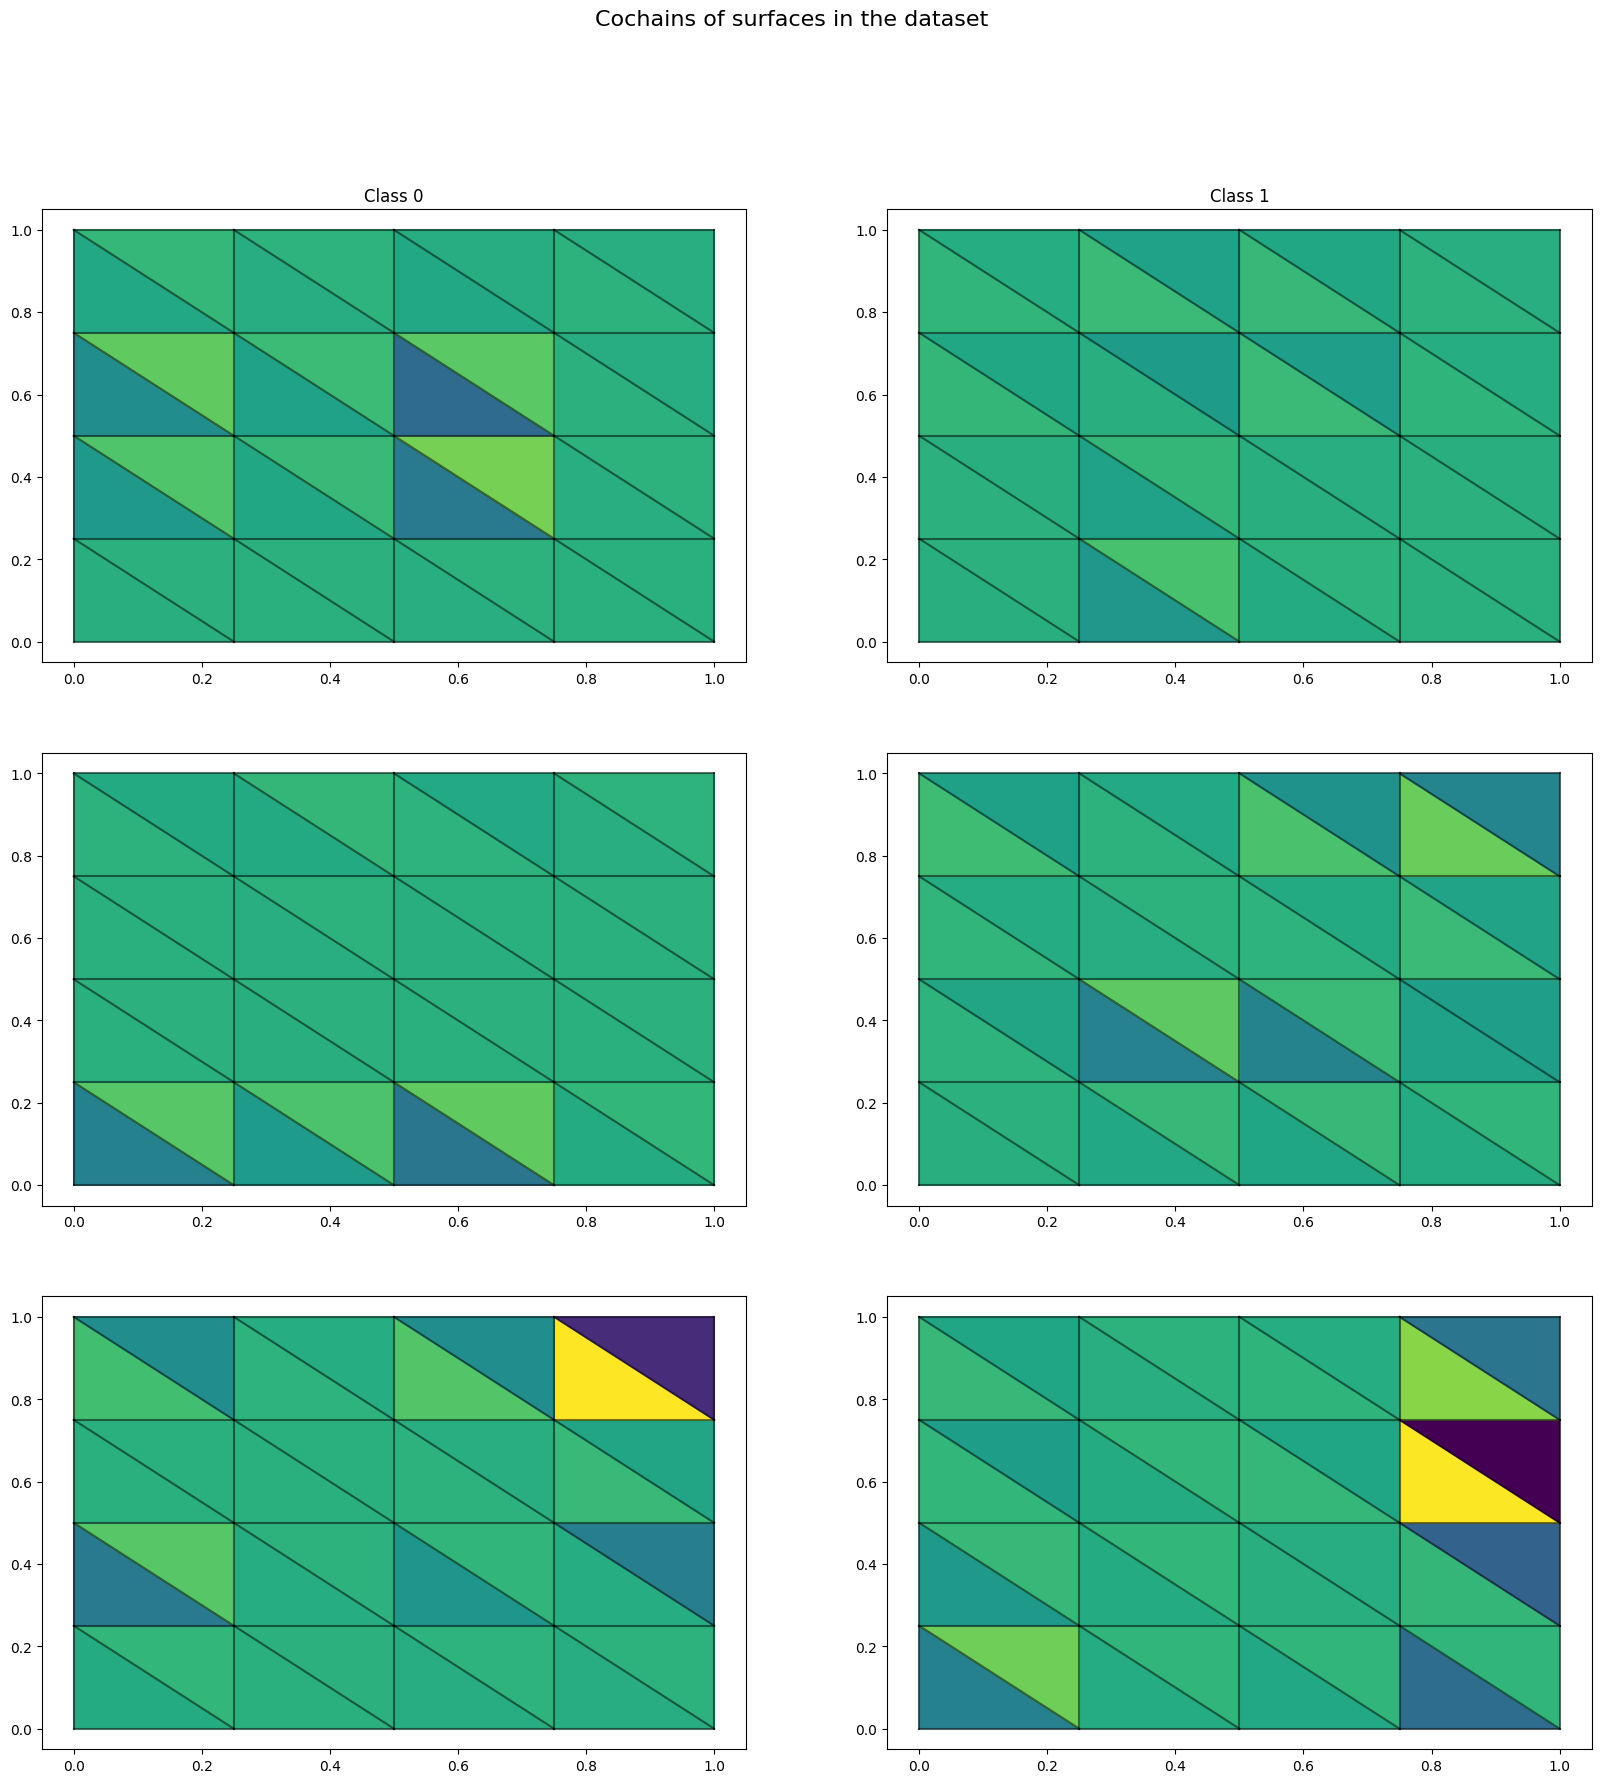

In [29]:
vis.plot_comparison_cochains_indices(cochain0, points, simplices, ac, [3,4,5], [7,8,9])

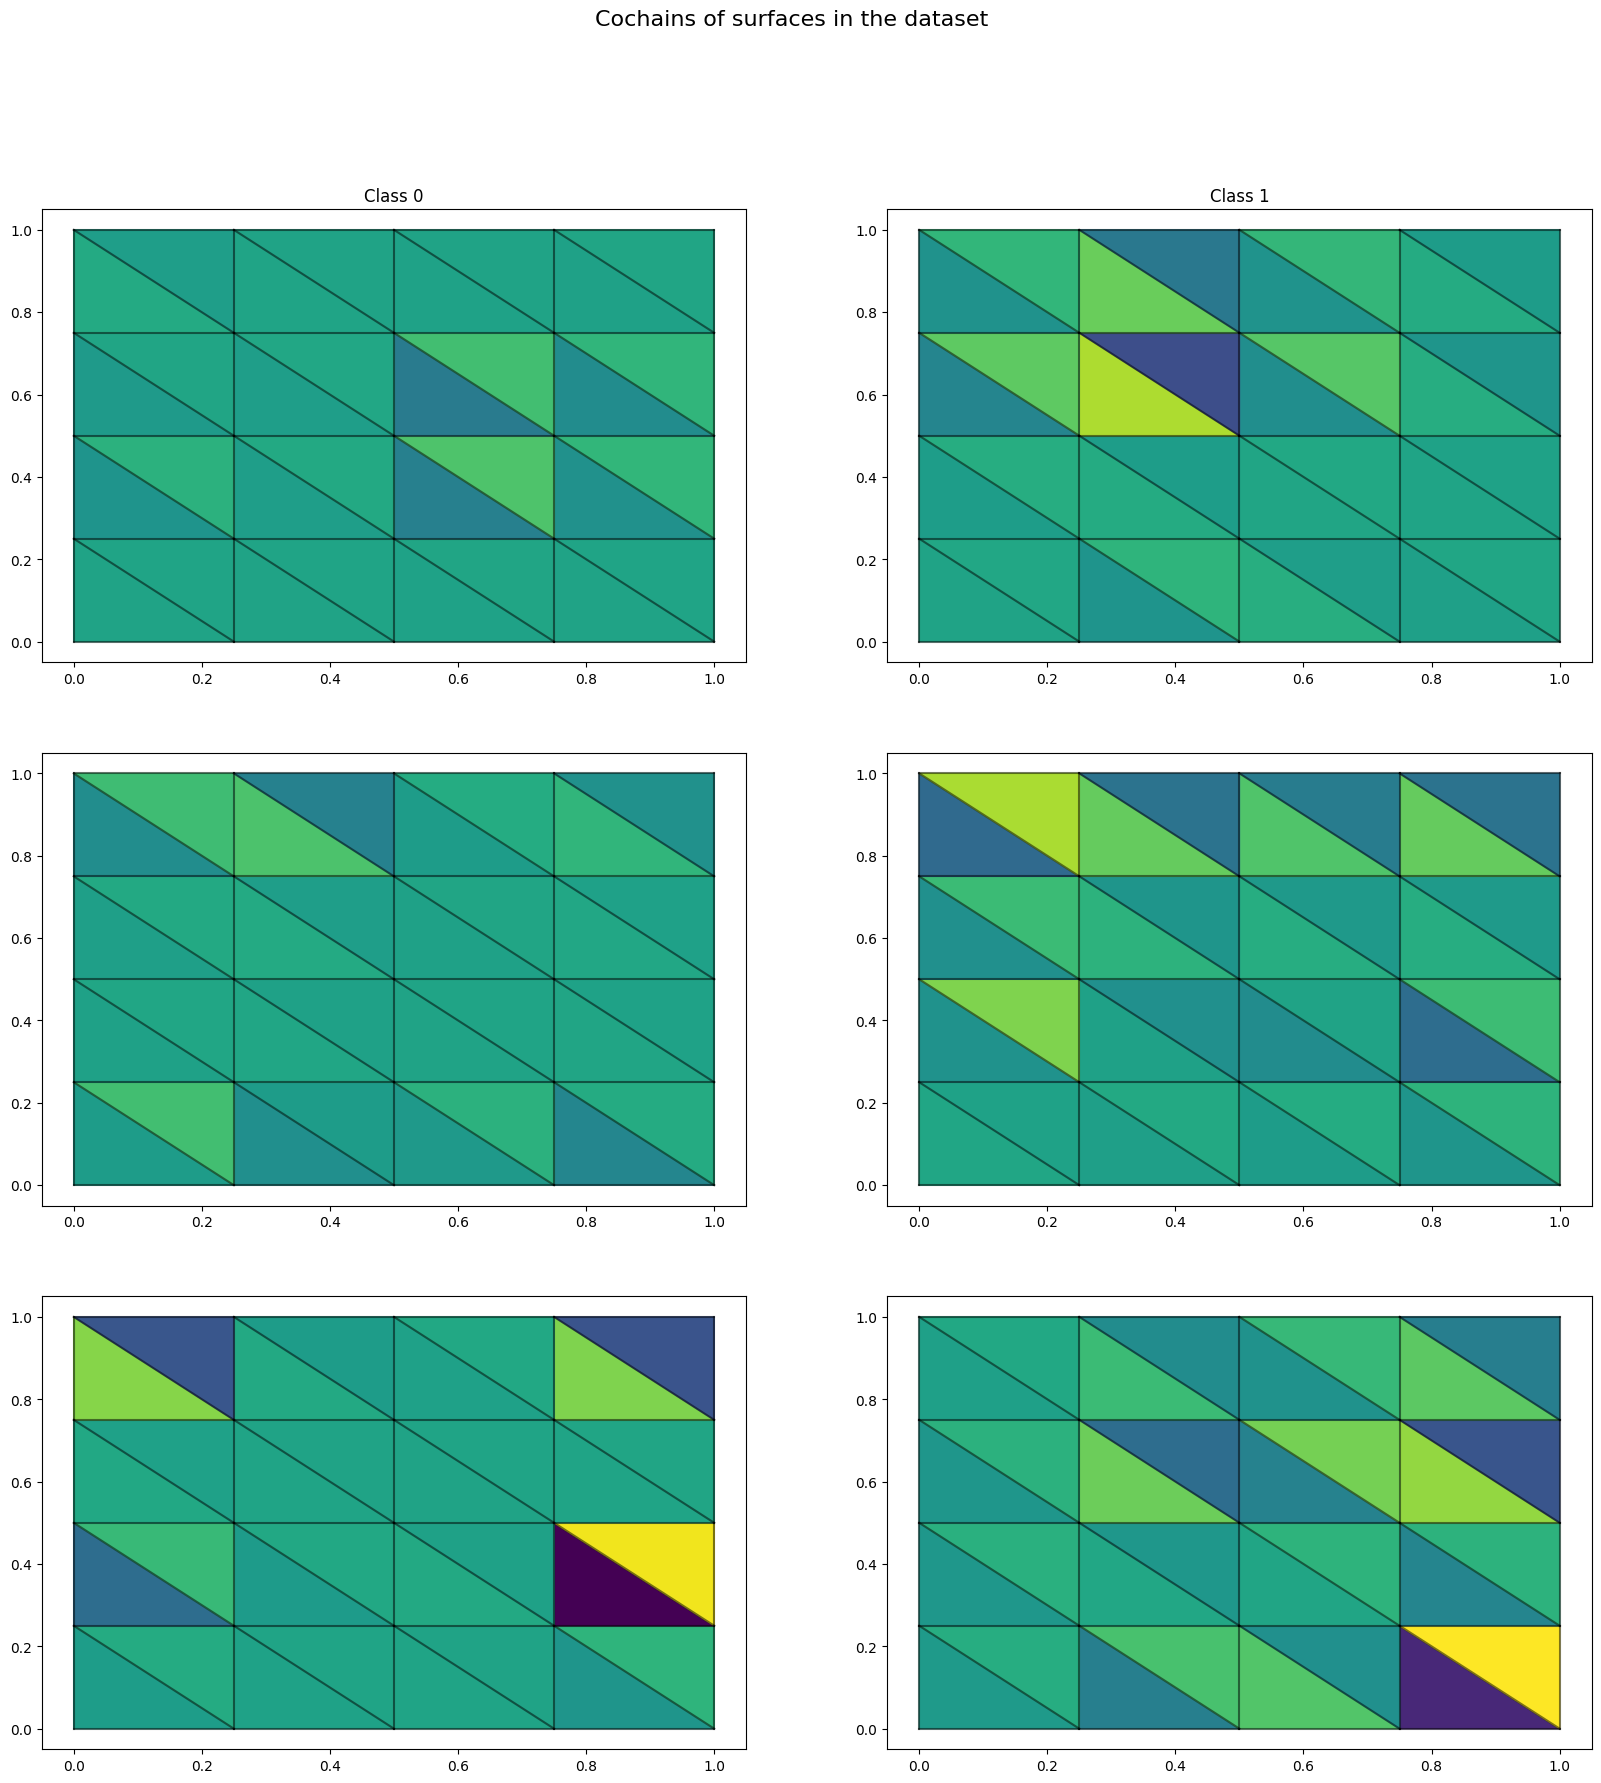

In [30]:
vis.plot_comparison_cochains_indices(cochain1, points, simplices, ac, [3,4,5], [7,8,9])